# COVID19-related literature SQL database

In this notebook, we create a relational database dump of a set of COVID19-related publication datasets. These include:

* CORD19: https://pages.semanticscholar.org/coronavirus-research
* Dimensions: https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255
* WHO: https://www.who.int/emergencies/diseases/novel-coronavirus-2019/global-research-on-novel-coronavirus-2019-ncov

In [145]:
# magics, warnings and imports

%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, math, re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import Integer,String,Boolean,DateTime

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load datasets

In [146]:
# point here to the versions of the datasets you want to use
dimensions_filename = "datasets_input/Dimensions_20_05_2020.csv"
who_filename = "datasets_input/WHO_20_05_2020.csv"
cord19_folder = "datasets_input/CORD19_2020_05_20"

df_dimensions = pd.read_csv(dimensions_filename, dtype=str)
df_who = pd.read_csv(who_filename, dtype=str)
df_cord = pd.read_csv(os.path.join(cord19_folder,"metadata.csv"), dtype=str)

In [147]:
df_cord.shape

(128492, 19)

### Prepare dataframes for ingestion

#### Clean-up data frames

##### Dimensions

In [148]:
df_dimensions.head()

,Date added,Publication ID,DOI,PMID,PMCID,Title,Abstract,Source title,Source UID,Publisher,...,Research Organizations - standardized,GRID IDs,City of Research organization,Country of Research organization,Funder,UIDs of supporting grants,Times cited,Altmetric,Source Linkout,Dimensions URL
0,2020-05-15,pub.1127568354,10.3238/arztebl.2020.0364,NaN,NaN,SARS-CoV-2 pandemic—a complicated case of appe...,NaN,Deutsches Aerzteblatt Online,jour.1040139,Deutscher Arzte-Verlag GmbH,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,https://app.dimensions.ai/details/publication/...
1,2020-05-15,pub.1127580866,10.12957/tamoios.2020.50511,NaN,NaN,COLAPSO E DETERMINISMO ESCALAR EM TEMPOS PANDÊ...,O texto consiste em um exercício metodológico ...,Revista Tamoios,jour.1146824,Universidade de Estado do Rio de Janeiro,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,https://www.e-publicacoes.uerj.br/index.php/ta...,https://app.dimensions.ai/details/publication/...
2,2020-05-15,pub.1127584866,10.26434/chemrxiv.12280532,NaN,NaN,Computational Guided Identification of Novel P...,"<p>The Coronavirus Disease 2019 (COVID-19), ca...",ChemRxiv,jour.1315496,American Chemical Society (ACS),...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,https://chemrxiv.org/articles/Computational_Gu...,https://app.dimensions.ai/details/publication/...
3,2020-05-15,pub.1127563585,10.2106/jbjs.20.00610,NaN,NaN,The “Infodemic” of Journal Publication Associa...,NaN,The Journal of Bone and Joint Surgery (American),jour.1002308,Wolters Kluwer,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,https://app.dimensions.ai/details/publication/...
4,2020-05-15,pub.1127571457,10.5089/9781513541464.002,NaN,NaN,Haiti,Staff Report prepared by a staff team of the I...,IMF Staff Country Reports,jour.1137046,International Monetary Fund (IMF),...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,https://www.elibrary.imf.org/doc/IMF002/28987-...,https://app.dimensions.ai/details/publication/...


In [149]:
df_dimensions.columns

Index(['Date added', 'Publication ID', 'DOI', 'PMID', 'PMCID', 'Title',
       'Abstract', 'Source title', 'Source UID', 'Publisher', 'MeSH terms',
       'Publication Date', 'PubYear', 'Volume', 'Issue', 'Pagination',
       'Open Access', 'Publication Type', 'Authors', 'Corresponding Authors',
       'Authors Affiliations', 'Research Organizations - standardized',
       'GRID IDs', 'City of Research organization',
       'Country of Research organization', 'Funder',
       'UIDs of supporting grants', 'Times cited', 'Altmetric',
       'Source Linkout', 'Dimensions URL'],
      dtype='object')

In [150]:
df_dimensions.drop(columns=['Date added', 'Publisher', 'Authors', 'Corresponding Authors',
       'Authors Affiliations', 'Research Organizations - standardized',
       'GRID IDs', 'City of Research organization',
       'Country of Research organization', 'Funder',
       'UIDs of supporting grants', 'Times cited', 'Altmetric',
       'Source Linkout'], inplace=True)

In [151]:
df_dimensions.columns

Index(['Publication ID', 'DOI', 'PMID', 'PMCID', 'Title', 'Abstract',
       'Source title', 'Source UID', 'MeSH terms', 'Publication Date',
       'PubYear', 'Volume', 'Issue', 'Pagination', 'Open Access',
       'Publication Type', 'Dimensions URL'],
      dtype='object')

In [152]:
df_dimensions.rename(columns={'Publication ID':'dimensions_id', 'DOI':'doi', 'PMID':'pmid', 'PMCID':'pmcid', 'Title':'title', 'Abstract':'abstract',
       'Source title':'journal', 'Source UID':'source_uid', 'MeSH terms':'mesh_terms', 'Publication Date':'publication_date',
       'PubYear':'publication_year', 'Volume':'volume', 'Issue':'issue', 'Pagination':'pages', 'Open Access':'open_access',
       'Publication Type':'publication_type', 'Dimensions URL':'dimensions_url'}, inplace=True)

In [153]:
def get_year(date):
    if isinstance(date,str) and len(date)>3 and date[:4].isdigit():
        return date[:4]
    return ""

month_to_number = {"Jan":"1","Feb":"2","Mar":"3","Apr":"4","May":"5","Jun":"6","Jul":"7","Aug":"8","Sep":"9","Oct":"10","Nov":"11","Dec":"12"}

def get_month(date):
    if isinstance(date,str) and len(date)>6:
        if "-" in date and date.split("-")[1].isdigit():
            return str(int(date.split("-")[1]))
        else:
            try:
                return month_to_number[date.split()[1]]
            except:
                return ""
    return ""

def sanitize_string(s):
    return " ".join(s.split())

In [154]:
df_dimensions["publication_year"] = df_dimensions["publication_year"].apply(get_year)
df_dimensions["publication_month"] = df_dimensions["publication_date"].apply(get_month)
df_dimensions["arxiv_id"] = ""

In [155]:
df_dimensions.drop(columns="publication_date", inplace=True)
df_dimensions = df_dimensions.fillna('')

In [156]:
# retrieve arXiv ID for Dimensions papers
# Sync option, quite slow

"""
import requests, re

for index, row in df_dimensions[df_dimensions.journal=="arXiv"].iterrows():
    r = requests.get(row["dimensions_url"])
    if r.status_code == 200:
        arxiv_url = re.search("https://arxiv.org/pdf/arXiv:[0-9]+.[0-9]+",r.text).group()
        arxiv_id = arxiv_url.split(":")[-1]
        row["arxiv_id"] = arxiv_id
"""

'\nimport requests, re\n\nfor index, row in df_dimensions[df_dimensions.journal=="arXiv"].iterrows():\n    r = requests.get(row["dimensions_url"])\n    if r.status_code == 200:\n        arxiv_url = re.search("https://arxiv.org/pdf/arXiv:[0-9]+.[0-9]+",r.text).group()\n        arxiv_id = arxiv_url.split(":")[-1]\n        row["arxiv_id"] = arxiv_id\n'

In [157]:
# from https://towardsdatascience.com/fast-and-async-in-python-accelerate-your-requests-using-asyncio-62dafca83c33
# aSync option, fast

import aiohttp
import requests
import asyncio

from aiohttp import ClientSession

def extract_fields_from_response(response):
    """Extract arxiv id from API's response"""
    search_res = re.search("arXiv:[0-9]+.[0-9]+",response)
    if search_res:
        arxiv_url = search_res.group()
        arxiv_id = arxiv_url.split(":")[-1]
        return arxiv_id
    return ""

async def get_details_async(session, payload):   
    response = await session.request(method='GET', url=payload[1]["dimensions_url"])
    if response.status != 200:
        print(payload[0], response.status)
        pass
    return await response.text()

async def run_program(session, payload):
    """Wrapper for running program in an asynchronous manner"""
    response = await get_details_async(session, payload)
    arxiv_id = extract_fields_from_response(response)
    return (arxiv_id,payload[1]["dimensions_url"])

payloads = df_dimensions[df_dimensions.journal=="arXiv"]
connector = aiohttp.TCPConnector(limit=5)
async with aiohttp.ClientSession(connector=connector) as session:
    results = await asyncio.gather(*[run_program(session, payload) for payload in payloads.iterrows()])

In [158]:
df_tmp = pd.DataFrame.from_dict({"arxiv_id":[x[0] for x in results],"dimensions_url":[x[1] for x in results]})

In [159]:
df_tmp.shape

(861, 2)

In [160]:
df_dimensions = df_dimensions.merge(df_tmp, how="left", left_on="dimensions_url", right_on="dimensions_url")
df_dimensions.drop(columns="arxiv_id_x", inplace=True)
df_dimensions.rename(columns={"arxiv_id_y":"arxiv_id"}, inplace=True)
df_dimensions = df_dimensions.fillna('')

In [161]:
df_dimensions.shape

(32442, 18)

In [162]:
df_dimensions[df_dimensions.journal=="arXiv"].shape

(861, 18)

In [163]:
df_dimensions.head()

,dimensions_id,doi,pmid,pmcid,title,abstract,journal,source_uid,mesh_terms,publication_year,volume,issue,pages,open_access,publication_type,dimensions_url,publication_month,arxiv_id
0,pub.1127568354,10.3238/arztebl.2020.0364,,,SARS-CoV-2 pandemic—a complicated case of appe...,,Deutsches Aerzteblatt Online,jour.1040139,,2020,,,,Closed,article,https://app.dimensions.ai/details/publication/...,5,
1,pub.1127580866,10.12957/tamoios.2020.50511,,,COLAPSO E DETERMINISMO ESCALAR EM TEMPOS PANDÊ...,O texto consiste em um exercício metodológico ...,Revista Tamoios,jour.1146824,,2020,16,1,,All OA; Bronze,article,https://app.dimensions.ai/details/publication/...,5,
2,pub.1127584866,10.26434/chemrxiv.12280532,,,Computational Guided Identification of Novel P...,"<p>The Coronavirus Disease 2019 (COVID-19), ca...",ChemRxiv,jour.1315496,,2020,,,,"All OA; Green, Published",preprint,https://app.dimensions.ai/details/publication/...,5,
3,pub.1127563585,10.2106/jbjs.20.00610,,,The “Infodemic” of Journal Publication Associa...,,The Journal of Bone and Joint Surgery (American),jour.1002308,,2020,,,1,Closed,article,https://app.dimensions.ai/details/publication/...,5,
4,pub.1127571457,10.5089/9781513541464.002,,,Haiti,Staff Report prepared by a staff team of the I...,IMF Staff Country Reports,jour.1137046,,2020,20,121,,All OA; Bronze,article,https://app.dimensions.ai/details/publication/...,4,


In [164]:
df_dimensions[df_dimensions.doi==""].shape

(1201, 18)

##### WHO

In [165]:
df_who.head()

,Title,Authors,Abstract,Published Year,Published Month,Journal,Volume,Issue,Pages,Accession Number,DOI,Ref,Covidence #,Study,Notes,Tags,Cov Num
0,Recent advances in the detection of respirator...,"Zhang, N.; Wang, L.; Deng, X.; Liang, R.; Su, ...",Respiratory tract viral infection caused by vi...,2020,NaN,Journal of medical virology,NaN,NaN,NaN,31944312,10.1002/jmv.25674,6,#2,Zhang 2020,NaN,"* Narrative review; Clinical aspects, diagnosi...",2
1,"Pneumonia of Unknown Etiology in Wuhan, China:...","Bogoch, I. I.; Watts, A.; Thomas-Bachli, A.; H...",There is currently an outbreak of a pneumonia ...,2020,NaN,Journal of travel medicine,NaN,NaN,NaN,NaN,10.1093/jtm/taaa008,13,#4,Bogoch 2020,Jose Garnica (2020-01-29 23:40:16)(Included):...,* Case study/series; * Epidemiological study; ...,4
2,A Novel Coronavirus from Patients with Pneumon...,"Zhu, N.; Zhang, D.; Wang, W.; Li, X.; Yang, B....","In December 2019, a cluster of patients with p...",2020,NaN,The New England journal of medicine,NaN,NaN,NaN,31978945,10.1056/NEJMoa2001017,24,#8,Zhu 2020,NaN,NaN,8
3,A Novel Coronavirus Emerging in China - Key Qu...,"Munster, V. J.; Koopmans, M.; van Doremalen, N...",NaN,2020,NaN,The New England journal of medicine,NaN,NaN,NaN,31978293,10.1056/NEJMp2000929,25,#9,Munster 2020,NaN,NaN,9
4,Molecular mechanism for antibody-dependent enh...,"Wan, Y.; Shang, J.; Sun, S.; Tai, W.; Chen, J....",Antibody-dependent enhancement (ADE) of viral ...,2019,NaN,Journal of virology,NaN,NaN,NaN,NaN,10.1128/JVI.02015-19,15,#10,Wan 2019,NaN,"Other related diseases and viruses; Virology, ...",10


In [166]:
df_who.columns

Index(['Title', 'Authors', 'Abstract', 'Published Year', 'Published Month',
       'Journal', 'Volume', 'Issue', 'Pages', 'Accession Number', 'DOI', 'Ref',
       'Covidence #', 'Study', 'Notes', 'Tags', 'Cov Num'],
      dtype='object')

In [167]:
df_who.drop(columns="Authors", inplace=True)

In [168]:
df_who.rename(columns={'Title':'title', 'Abstract':'abstract', 'Published Year':'publication_year', 'Published Month':'publication_month',
       'Journal':'journal', 'Volume':'volume', 'Issue':'issue', 'Pages':'pages', 'Accession Number':'accession_number', 'DOI':'doi', 'Ref':'ref',
       'Covidence #':'covidence', 'Study':'study', 'Notes':'notes', 'Tags':'tags'}, inplace=True)

In [169]:
df_who["pmid"] = ""
df_who["pmcid"] = ""
df_who["dimensions_id"] = ""
df_who["arxiv_id"] = ""
df_who = df_who.fillna('')

In [170]:
df_who.head()

,title,abstract,publication_year,publication_month,journal,volume,issue,pages,accession_number,doi,ref,covidence,study,notes,tags,Cov Num,pmid,pmcid,dimensions_id,arxiv_id
0,Recent advances in the detection of respirator...,Respiratory tract viral infection caused by vi...,2020,,Journal of medical virology,,,,31944312,10.1002/jmv.25674,6,#2,Zhang 2020,,"* Narrative review; Clinical aspects, diagnosi...",2,,,,
1,"Pneumonia of Unknown Etiology in Wuhan, China:...",There is currently an outbreak of a pneumonia ...,2020,,Journal of travel medicine,,,,,10.1093/jtm/taaa008,13,#4,Bogoch 2020,Jose Garnica (2020-01-29 23:40:16)(Included):...,* Case study/series; * Epidemiological study; ...,4,,,,
2,A Novel Coronavirus from Patients with Pneumon...,"In December 2019, a cluster of patients with p...",2020,,The New England journal of medicine,,,,31978945,10.1056/NEJMoa2001017,24,#8,Zhu 2020,,,8,,,,
3,A Novel Coronavirus Emerging in China - Key Qu...,,2020,,The New England journal of medicine,,,,31978293,10.1056/NEJMp2000929,25,#9,Munster 2020,,,9,,,,
4,Molecular mechanism for antibody-dependent enh...,Antibody-dependent enhancement (ADE) of viral ...,2019,,Journal of virology,,,,,10.1128/JVI.02015-19,15,#10,Wan 2019,,"Other related diseases and viruses; Virology, ...",10,,,,


In [171]:
df_who[df_who.doi==""].shape

(1784, 20)

##### CORD19

In [172]:
df_cord.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [173]:
df_cord["license"].value_counts()

unk            61802
no-cc          32803
cc-by          11891
els-covid      11702
medrxiv         3186
cc-by-nc        1531
arxiv           1348
cc-by-nc-nd      899
green-oa         872
biorxiv          864
bronze-oa        586
cc-by-nc-sa      551
cc0              280
hybrid-oa        128
gold-oa           41
cc-by-nd           6
cc-by-sa           2
Name: license, dtype: int64

In [174]:
df_cord["source_x"].value_counts()

Medline                               49338
PMC                                   25512
Medline; PMC                          14955
WHO                                    9931
Elsevier; Medline; PMC                 9809
Elsevier; PMC                          5899
MedRxiv                                2958
Medline; WHO                           2407
Elsevier; Medline; PMC; WHO            2376
Medline; PMC; WHO                      1444
ArXiv                                  1329
BioRxiv                                 752
Elsevier; PMC; WHO                      555
Elsevier                                351
BioRxiv; MedRxiv                        338
PMC; WHO                                171
Elsevier; Medline                       126
Elsevier; Medline; WHO                  125
Elsevier; WHO                            48
ArXiv; Medline; PMC                      21
ArXiv; Elsevier; Medline; PMC            13
ArXiv; Medline                           12
ArXiv; Elsevier; Medline; PMC; W

In [175]:
# how many full text files
df_cord[(pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files))].shape

(58457, 19)

In [176]:
df_cord[(pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files))].shape[0]/df_cord.shape[0]

0.4549466114621922

In [177]:
# check Medline
df_cord[(df_cord.source_x=="Medline")&((pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files)))].shape[0]/df_cord[(df_cord.source_x=="Medline")].shape[0]

0.0

In [178]:
df_cord[(df_cord.source_x=="Medline")].shape[0]

49338

In [179]:
# check NOT Medline
df_cord[(df_cord.source_x!="Medline")&((pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files)))].shape[0]/df_cord[(df_cord.source_x!="Medline")].shape[0]

0.7385223741061728

In [180]:
df_cord[(df_cord.source_x!="Medline")].shape[0]

79154

In [181]:
# NEW columns (for now, we drop)
df_cord.drop(columns=["cord_uid","url","pdf_json_files","pmc_json_files","s2_id"],inplace=True)

In [182]:
df_cord.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id'],
      dtype='object')

In [183]:
df_cord.drop(columns='authors', inplace=True)
df_cord = df_cord.fillna('')

In [184]:
df_cord.rename(columns={'source_x':'source', 'pubmed_id': 'pmid',
       'mag_id': 'ms_academic_id', 'who_covidence_id': 'who_covidence'}, inplace=True)

In [185]:
df_cord["publication_year"] = df_cord["publish_time"].apply(get_year)
df_cord["publication_month"] = df_cord["publish_time"].apply(get_month)

In [186]:
df_cord.drop(columns='publish_time', inplace=True)

In [187]:
df_cord['pages'] = ""
df_cord['volume'] = ""
df_cord['issue'] = ""
df_cord["dimensions_id"] = ""

In [188]:
df_cord.head()

,sha,source,title,doi,pmcid,pmid,license,abstract,journal,ms_academic_id,who_covidence,arxiv_id,publication_year,publication_month,pages,volume,issue,dimensions_id
0,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,BMC Infect Dis,,,,2001,7,,,,
1,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,Respir Res,,,,2000,8,,,,
2,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,Respir Res,,,,2000,8,,,,
3,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,Respir Res,,,,2001,2,,,,
4,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,Respir Res,,,,2001,5,,,,


In [189]:
df_cord[(df_cord.doi=="") & ((df_cord.sha!="") | (df_cord.pmid!="") | (df_cord.pmcid!="") | df_cord.arxiv_id!="")].shape

(27906, 18)

In [190]:
df_cord[(df_cord.doi=="") & (df_cord.pmid=="") & (df_cord.pmcid=="")].shape

(10474, 18)

In [191]:
df_cord[((df_cord.doi=="") & (df_cord.pmid=="") & (df_cord.pmcid==""))&(df_cord.arxiv_id!="")].shape

(1273, 18)

In [192]:
df_dimensions.shape

(32442, 18)

In [193]:
df_who.shape

(20641, 20)

In [194]:
df_cord.shape

(128492, 18)

In [195]:
df_dimensions[((df_dimensions.doi=="") & (df_dimensions.pmid=="") & (df_dimensions.pmcid==""))&(df_dimensions.journal=="arXiv")].shape

(861, 18)

In [196]:
df_dimensions[df_dimensions.journal=="arXiv"].shape

(861, 18)

In [197]:
df_cord[df_cord.arxiv_id!=""].shape

(1395, 18)

In [198]:
df_cord[df_cord.title=="CORD-19: The Covid-19 Open Research Dataset"]

,sha,source,title,doi,pmcid,pmid,license,abstract,journal,ms_academic_id,who_covidence,arxiv_id,publication_year,publication_month,pages,volume,issue,dimensions_id
82751,bc411487f305e451d7485e53202ec241fcc97d3b,ArXiv,CORD-19: The Covid-19 Open Research Dataset,,,,arxiv,The Covid-19 Open Research Dataset (CORD-19) i...,,,,2004.10706,2020,4,,,,


In [199]:
df_dimensions[df_dimensions.title=="CORD-19: The Covid-19 Open Research Dataset"]

,dimensions_id,doi,pmid,pmcid,title,abstract,journal,source_uid,mesh_terms,publication_year,volume,issue,pages,open_access,publication_type,dimensions_url,publication_month,arxiv_id
13048,pub.1126924428,,,,CORD-19: The Covid-19 Open Research Dataset,The Covid-19 Open Research Dataset (CORD-19) i...,arXiv,jour.1371339,,2020,,,,"All OA; Green, Submitted",preprint,https://app.dimensions.ai/details/publication/...,4,2004.10706


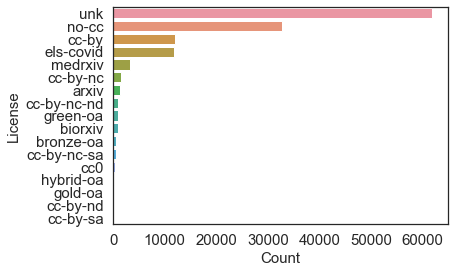

In [200]:
# license
df_sub = df_cord[df_cord.license.isin(df_cord.license.value_counts()[:30].index.tolist())]
b = sns.countplot(y="license", data=df_sub, order=df_sub['license'].value_counts().index)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Count",fontsize=15)
b.set_ylabel("License",fontsize=15)
b.tick_params(labelsize=15)

### Prepare tables

In [201]:
# the main table: pub

In [202]:
pub_table_columns = ['title','abstract','publication_year','publication_month','journal','volume','issue','pages','doi','pmid','pmcid','dimensions_id','arxiv_id']

df_pub = df_dimensions[pub_table_columns].append(df_who[pub_table_columns], ignore_index = True)

In [203]:
df_pub = df_pub[pub_table_columns].append(df_cord[pub_table_columns], ignore_index=True)

In [204]:
df_pub["title"] = df_pub["title"].apply(sanitize_string)
df_pub["abstract"] = df_pub["abstract"].apply(sanitize_string)
df_pub["doi"] = df_pub["doi"].apply(str.lower)
df_pub["pmid"] = df_pub["pmid"].apply(str.lower)
df_pub["pmcid"] = df_pub["pmcid"].apply(str.lower)
df_pub["dimensions_id"] = df_pub["dimensions_id"].apply(str.lower)
df_pub["arxiv_id"] = df_pub["arxiv_id"].apply(str.lower)

In [205]:
df_pub.shape

(181575, 13)

In [206]:
df_pub[(df_pub.doi=="") & (df_pub.pmid=="") & (df_pub.pmcid=="") & (df_pub.dimensions_id=="") & (df_pub.arxiv_id=="")].shape

(10985, 13)

In [207]:
# check to have at least one valid identifier per publication
# we drop publications which do not: hopefully, they will be equipped with an identifier in future releases

df_pub = df_pub[~((df_pub.doi=="") & (df_pub.pmid=="") & (df_pub.pmcid=="") & (df_pub.dimensions_id=="") & (df_pub.arxiv_id==""))]

In [208]:
df_pub[df_pub.doi=="0.1126/science.abb7331"]

,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,dimensions_id,arxiv_id
34290,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020,,Science,,,,0.1126/science.abb7331,,,,


In [209]:
# drop duplicates, first on dois then pmids then pmcids. We need this to keep empty values!
df_tmp = df_pub[df_pub.doi==""]
df_pub1 = df_pub[df_pub.doi!=""].groupby('doi').first()
df_pub1.reset_index(inplace=True)
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_pub2 = df_tmp[df_tmp.pmid!=""].groupby('pmid').first()
df_pub2.reset_index(inplace=True)
df_tmp3 = df_tmp2[df_tmp2.pmcid==""]
df_pub3 = df_tmp2[df_tmp2.pmcid!=""].groupby('pmcid').first()
df_pub3.reset_index(inplace=True)
df_tmp4 = df_tmp3[df_tmp3.arxiv_id==""]
df_pub4 = df_tmp3[df_tmp3.arxiv_id!=""].groupby('arxiv_id').first()
df_pub4.reset_index(inplace=True)
df_pub5 = df_tmp4[df_tmp4.dimensions_id!=""].groupby('dimensions_id').first()
df_pub5.reset_index(inplace=True)

In [210]:
df_pub1[df_pub1.doi=="0.1126/science.abb7331"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id
0,0.1126/science.abb7331,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020,,Science,,,,,,,


In [211]:
df_pub = pd.concat([df_pub1,df_pub2,df_pub3,df_pub4,df_pub5])

In [212]:
# add PK and reset index
df_pub.reset_index(drop=True,inplace=True)
df_pub["pub_id"] = df_pub.index.values

In [213]:
df_pub.shape

(135052, 14)

In [214]:
df_pub[df_pub.arxiv_id=="2003.08720"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id
133965,,Social distancing versus early detection and c...,Different countries -- and sometimes different...,2020,3,arXiv,,,,,,pub.1126058658,2003.08720,133965


In [215]:
# create other tables via joins

df_datasource = pd.DataFrame.from_dict({"source":["CORD19","Dimensions","WHO"],"url":["https://pages.semanticscholar.org/coronavirus-research","https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255",
"https://www.who.int/emergencies/diseases/novel-coronavirus-2019/global-research-on-novel-coronavirus-2019-ncov"]})
df_cord_metadata = df_cord[['source','license','ms_academic_id','who_covidence','doi','pmid','pmcid','sha','arxiv_id']]
df_who_metadata = df_who[['accession_number', 'doi', 'ref',
       'covidence', 'study', 'notes', 'tags', 'pmid', 'pmcid']]
df_dimensions_metadata = df_dimensions[['dimensions_id', 'doi', 'pmid', 'pmcid','arxiv_id', 'source_uid', 'mesh_terms',
       'open_access', 'publication_type', 'dimensions_url']]

In [216]:
df_cord_metadata["doi"] = df_cord_metadata["doi"].apply(str.lower)
df_cord_metadata["pmid"] = df_cord_metadata["pmid"].apply(str.lower)
df_cord_metadata["pmcid"] = df_cord_metadata["pmcid"].apply(str.lower)
df_who_metadata["doi"] = df_who_metadata["doi"].apply(str.lower)
df_who_metadata["pmid"] = df_who_metadata["pmid"].apply(str.lower)
df_who_metadata["pmcid"] = df_who_metadata["pmcid"].apply(str.lower)
df_dimensions_metadata["doi"] = df_dimensions_metadata["doi"].apply(str.lower)
df_dimensions_metadata["pmid"] = df_dimensions_metadata["pmid"].apply(str.lower)
df_dimensions_metadata["pmcid"] = df_dimensions_metadata["pmcid"].apply(str.lower)

In [217]:
df_datasource.head()

,source,url
0,CORD19,https://pages.semanticscholar.org/coronavirus-...
1,Dimensions,https://docs.google.com/spreadsheets/d/1-kTZJZ...
2,WHO,https://www.who.int/emergencies/diseases/novel...


In [218]:
# CORD19 metadata

In [219]:
df_cord_metadata.shape

(128492, 9)

In [220]:
df_pub[df_pub.doi=="0.1126/science.abb7331"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id
0,0.1126/science.abb7331,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020,,Science,,,,,,,,0


In [221]:
#We need this to keep empty values!

df_tmp = df_cord_metadata[df_cord_metadata.doi==""]
df_cord_metadata1 = pd.merge(df_cord_metadata[df_cord_metadata.doi!=""], df_pub[['pub_id','doi']],  how='inner', left_on=['doi'], right_on=['doi'])
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_cord_metadata2 = pd.merge(df_tmp[df_tmp.pmid!=""], df_pub[['pub_id','pmid']],  how='inner', left_on=['pmid'], right_on=['pmid'])
df_tmp3 = df_tmp2[df_tmp2.pmcid==""]
df_cord_metadata3 = pd.merge(df_tmp2[df_tmp2.pmcid!=""], df_pub[['pub_id','pmcid']],  how='inner', left_on=['pmcid'], right_on=['pmcid'])
df_cord_metadata4 = pd.merge(df_tmp3[df_tmp3.arxiv_id!=""], df_pub[['pub_id','arxiv_id']],  how='inner', left_on=['arxiv_id'], right_on=['arxiv_id'])

In [222]:
df_cord_metadata1 = df_cord_metadata1.groupby("doi").first()
df_cord_metadata1.reset_index(inplace=True)
df_cord_metadata2 = df_cord_metadata2.groupby("pmid").first()
df_cord_metadata2.reset_index(inplace=True)
df_cord_metadata3 = df_cord_metadata3.groupby("pmcid").first()
df_cord_metadata3.reset_index(inplace=True)
df_cord_metadata4 = df_cord_metadata4.groupby("arxiv_id").first()
df_cord_metadata4.reset_index(inplace=True)

In [223]:
df_cord_metadata = pd.concat([df_cord_metadata1,df_cord_metadata2,df_cord_metadata3,df_cord_metadata4])

In [224]:
df_cord_metadata.shape

(118597, 10)

In [78]:
# read full texts in
folders = ['document_parses/pdf_json']
shas = list()
full_texts = list()

for folder in folders:
    for root, dirs, files in os.walk(os.path.join(cord19_folder,folder)):
        for file in tqdm(files):
            if ".json" in file: # read
                data = json.loads(codecs.open(os.path.join(root,file)).read())
                sha = data["paper_id"]
                full_text = " ".join(sanitize_string(section["text"]) for section in data["body_text"])
                shas.append(sha)
                full_texts.append(full_text)

In [225]:
df_cord_fulltext = pd.DataFrame.from_dict({"sha":shas,"full_text":full_texts})

In [226]:
df_cord_fulltext.shape

(59561, 2)

In [227]:
df_cord_metadata = pd.merge(df_cord_metadata, df_cord_fulltext,  how='left', left_on=['sha'], right_on=['sha'])
df_cord_metadata = df_cord_metadata.fillna('')
df_cord_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [228]:
df_cord_metadata.head()

,doi,source,license,ms_academic_id,who_covidence,pmid,pmcid,sha,arxiv_id,pub_id,full_text
0,10.0376/cma.j.issn.0376-2491.2020.0002,Medline; WHO,unk,,#615,32036640,,,,1,
1,10.1001/amajethics.2020.344,Medline,unk,,,32345430,,,,2,
2,10.1001/archdermatol.2010.96,Medline,unk,,,20566928,,,,3,
3,10.1001/archdermatol.2011.52,Medline,unk,,,21482889,,,,4,
4,10.1001/archfacial.2010.34,Medline,unk,,,20479429,,,,5,


In [229]:
df_cord_metadata[df_cord_metadata.arxiv_id!=""].head()

,doi,source,license,ms_academic_id,who_covidence,pmid,pmcid,sha,arxiv_id,pub_id,full_text
14941,10.1007/s10494-011-9345-0,ArXiv,arxiv,,,,,,1305.2885,15808,
15490,10.1007/s10955-013-0690-3,ArXiv,arxiv,,,,,67326b132f0b8258c4cd41a517b2d65404d58901,1211.2163,16372,that the population within a single subpopulat...
15491,10.1007/s10955-014-1024-9,ArXiv; PMC,no-cc,,,26074625,pmc4457089,535448073c1721a7928c2814283c5cda6e151902; 2305...,1402.7011,16373,
15750,10.1007/s11232-014-0210-x,ArXiv; PMC,arxiv,,,,pmc7149039,8abce2326a7c9a4f589e3bfe3480b766f7fd5d5e; 2239...,1406.7468,16639,
16248,10.1007/s11433-013-5321-0,ArXiv; Medline; PMC,arxiv,,,32288765,pmc7111546,7efbb19025f7bb3da296980c50e4e0edc4a340b3; c742...,1304.5603,17150,


In [230]:
# WHO and Dimensions metadata

In [231]:
df_tmp = df_who_metadata[df_who_metadata.doi==""]
df_who_metadata1 = pd.merge(df_who_metadata[df_who_metadata.doi!=""], df_pub[['pub_id','doi']],  how='inner', left_on=['doi'], right_on=['doi'])
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_who_metadata2 = pd.merge(df_tmp[df_tmp.pmid!=""], df_pub[['pub_id','pmid']],  how='inner', left_on=['pmid'], right_on=['pmid'])
df_who_metadata3 = pd.merge(df_tmp2[df_tmp2.pmcid!=""], df_pub[['pub_id','pmcid']],  how='inner', left_on=['pmcid'], right_on=['pmcid'])

In [232]:
df_who_metadata1 = df_who_metadata1.groupby("doi").first()
df_who_metadata1.reset_index(inplace=True)
df_who_metadata2 = df_who_metadata2.groupby("pmid").first()
df_who_metadata2.reset_index(inplace=True)
df_who_metadata3 = df_who_metadata3.groupby("pmcid").first()
df_who_metadata3.reset_index(inplace=True)

In [233]:
df_who_metadata = pd.concat([df_who_metadata1,df_who_metadata2,df_who_metadata3])

In [234]:
df_who_metadata.shape

(17893, 10)

In [235]:
df_who_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [236]:
df_tmp = df_dimensions_metadata[df_dimensions_metadata.dimensions_id==""]
df_dimensions_metadata1 = pd.merge(df_dimensions_metadata[df_dimensions_metadata.dimensions_id!=""], df_pub[['pub_id','dimensions_id']],  how='inner', left_on=['dimensions_id'], right_on=['dimensions_id'])

In [237]:
df_dimensions_metadata1 = df_dimensions_metadata1.groupby("dimensions_id").first()
df_dimensions_metadata1.reset_index(inplace=True)

In [238]:
df_dimensions_metadata = pd.concat([df_dimensions_metadata1])

In [239]:
df_dimensions_metadata.shape

(32226, 11)

In [240]:
df_dimensions_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [241]:
# Create datasource tables

In [242]:
cord_source_id = df_datasource[df_datasource.source=="CORD19"].index.values[0]
who_source_id = df_datasource[df_datasource.source=="WHO"].index.values[0]
dimensions_source_id = df_datasource[df_datasource.source=="Dimensions"].index.values[0]

In [243]:
df_cord_metadata["source_id"] = cord_source_id
df_who_metadata["source_id"] = who_source_id
df_dimensions_metadata["source_id"] = dimensions_source_id

In [244]:
df_pub_to_datasource = df_cord_metadata[["pub_id","source_id"]]
df_pub_to_datasource = df_pub_to_datasource.append(df_who_metadata[["pub_id","source_id"]],ignore_index=True)
df_pub_to_datasource = df_pub_to_datasource.append(df_dimensions_metadata[["pub_id","source_id"]],ignore_index=True)

In [245]:
df_pub_to_datasource.drop_duplicates(inplace=True)
df_pub_to_datasource.rename(columns={"source_id":"datasource_id"},inplace=True)

In [246]:
df_pub_to_datasource.shape

(162080, 2)

In [247]:
df_pub_to_datasource[df_pub_to_datasource.pub_id==22787]

,pub_id,datasource_id
21776,22787,0


In [248]:
# remove unnecessary columns
df_cord_metadata.drop(columns=['doi','pmid','pmcid','arxiv_id','source_id'],inplace=True)
df_who_metadata.drop(columns=['doi','pmid','pmcid','source_id'],inplace=True)
df_dimensions_metadata.drop(columns=['doi','pmid','pmcid','arxiv_id','source_id'],inplace=True)

In [249]:
# reset all indexes which will become PKs
df_cord_metadata.reset_index(drop=True,inplace=True)
df_who_metadata.reset_index(drop=True,inplace=True)
df_dimensions_metadata.reset_index(drop=True,inplace=True)
df_datasource.reset_index(drop=True,inplace=True)
df_cord_metadata["cord19_metadata_id"] = df_cord_metadata.index.values
df_who_metadata["who_metadata_id"] = df_who_metadata.index.values
df_dimensions_metadata["dimensions_metadata_id"] = df_dimensions_metadata.index.values
df_datasource["datasource_metadata_id"] = df_datasource.index.values

In [250]:
# make numeric where needed
df_pub["publication_year"] = pd.to_numeric(df_pub["publication_year"])
df_pub["publication_month"] = pd.to_numeric(df_pub["publication_month"])
df_pub["pmid"] = pd.to_numeric(df_pub["pmid"])

In [251]:
# add timestamp
df_pub["timestamp"] = pd.Timestamp.now()

In [252]:
# clean-up text (optional)
replaces = [""]

def clean_up(txt):
    for r in replaces:
        txt = txt.replace(r,"")
    return txt.encode('utf8', 'ignore').decode('utf8')
df_pub["abstract"] = [clean_up(a) for a in df_pub["abstract"].values]

In [253]:
df_pub.head()

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id,timestamp
0,0.1126/science.abb7331,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020.0,NaN,Science,,,,NaN,,,,0,2020-05-21 12:35:44.190709
1,10.0376/cma.j.issn.0376-2491.2020.0002,[Ten hot issues of breast cancer under the nov...,,2020.0,2.0,Chinese medical journal,100,0,e002,32036640.0,,pub.1124777091,,1,2020-05-21 12:35:44.190709
2,10.1001/amajethics.2020.344,Cohesion in Distancing.,"In isolation, we are physically apart; in soli...",2020.0,4.0,The AMA Journal of Ethic,22,4,e344-345,32345430.0,,pub.1127182341,,2,2020-05-21 12:35:44.190709
3,10.1001/archdermatol.2010.96,Fatal influenza A(H1N1) respiratory tract infe...,BACKGROUND The use of biologic agents represen...,2010.0,NaN,Archives of dermatology,,,,20566928.0,,,,3,2020-05-21 12:35:44.190709
4,10.1001/archdermatol.2011.52,Clinical correlations with dermatomyositis-spe...,OBJECTIVE To clarify the association of clinic...,2011.0,NaN,Archives of dermatology,,,,21482889.0,,,,4,2020-05-21 12:35:44.190709


In [254]:
# reorder the columns to match the SQL schema

df_datasource.columns

Index(['source', 'url', 'datasource_metadata_id'], dtype='object')

In [255]:
df_pub = df_pub[['pub_id', 'title', 'abstract', 'publication_year', 'publication_month', 'journal',
       'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid', 'dimensions_id', 'arxiv_id',
       'timestamp']]
df_who_metadata = df_who_metadata[['who_metadata_id', 'accession_number', 'ref', 'covidence', 'study', 'notes', 'tags',
       'pub_id']]
df_dimensions_metadata = df_dimensions_metadata[['dimensions_metadata_id', 'dimensions_id', 'source_uid', 'open_access',
       'publication_type', 'dimensions_url', 'mesh_terms', 'pub_id']]
df_cord_metadata = df_cord_metadata[[ 'cord19_metadata_id', 'source', 'license', 'ms_academic_id',
       'who_covidence', 'sha', 'full_text', 'pub_id']]
df_datasource = df_datasource[['datasource_metadata_id', 'source', 'url']]

In [256]:
df_pub.doi.value_counts()

                                     18518
10.1053/j.jvca.2016.01.021               1
10.1098/rstb.2011.0100                   1
10.1016/j.envint.2020.105689             1
10.1007/978-0-387-33012-9_18             1
                                     ...  
10.1007/s10986-014-9251-y                1
10.1016/j.jamcollsurg.2020.04.003        1
10.1186/s13054-014-0572-3                1
10.1097/ico.0000000000002397             1
10.1007/s15010-020-01408-5               1
Name: doi, Length: 116535, dtype: int64

In [257]:
df_pub.arxiv_id.value_counts()

              133638
2004.12799         2
2003.13071         2
2004.03715         2
2001.11021         2
               ...  
2004.08504         1
2005.03599         1
2004.07765         1
2005.00392         1
2005.08400         1
Name: arxiv_id, Length: 1408, dtype: int64

In [258]:
df_pub[df_pub.doi == "10.1016/s0140-6736(20)30607-3"].doi.to_string()

'45621    10.1016/s0140-6736(20)30607-3'

In [260]:
df_cord_metadata.columns

Index(['cord19_metadata_id', 'source', 'license', 'ms_academic_id',
       'who_covidence', 'sha', 'full_text', 'pub_id'],
      dtype='object')

### Dump to CSV

In [114]:
### Export the df_pub dataframe for further use

df_pub.to_csv("datasets_output/df_pub.csv", compression="gzip", index=False)

In [115]:
# export TSV for ingestion

df_pub.to_csv("datasets_output/sql_tables/pub.csv",index=False,sep="\t",header=False)
df_cord_metadata.to_csv("datasets_output/sql_tables/cord19_metadata.csv",index=False,sep="\t",header=False)
df_dimensions_metadata.to_csv("datasets_output/sql_tables/dimensions_metadata.csv",index=False,sep="\t",header=False)
df_who_metadata.to_csv("datasets_output/sql_tables/who_metadata.csv",index=False,sep="\t",header=False)
df_datasource.to_csv("datasets_output/sql_tables/datasource.csv",index=False,sep="\t",header=False)
df_pub_to_datasource.to_csv("datasets_output/sql_tables/pub_datasource.csv",index=False,sep="\t",header=False)

### Dump to MySQL

Use this if you want to create a MySQL db.

In [ ]:
dtype_dict = {'pub_id':Integer, 'title':String, 'abstract':String, 'publication_year':Integer, 'publication_month':Integer, 'journal':String,
       'volume':String, 'issue':String, 'pages':String, 'doi':String, 'pmid':Integer, 'pmcid':String, 'timestamp':DateTime}

In [ ]:
# get API key
import configparser
config = configparser.ConfigParser()
config.read("credentials/conf.ini")
mysql_username = config["MYSQL"]["username"]
mysql_password = config["MYSQL"]["password"]
mysql_database = config["MYSQL"]["database"]

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# main table
table_name = "pub"
try:
    frame = df_pub.to_sql(table_name, dbConnection, if_exists='append', index=False, index_label="pub_id", dtype=dtype_dict);
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table %s created successfully."%table_name);   
finally:
    dbConnection.close()

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# other tables
try:
    frame = df_cord_metadata.to_sql("cord19_metadata", dbConnection, if_exists='append', index=True, index_label="cord19_metadata_id")
    frame = df_who_metadata.to_sql("who_metadata", dbConnection, if_exists='append', index=True, index_label="who_metadata_id")
    frame = df_dimensions_metadata.to_sql("dimensions_metadata", dbConnection, if_exists='append', index=True, index_label="dimensions_metadata_id")
    frame = df_datasource.to_sql("datasource", dbConnection, if_exists='append', index=True, index_label="datasource_id")
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Tables created successfully.");   
finally:
    dbConnection.close()

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# last table
try:
    frame = df_pub_to_datasource.to_sql("pub_datasource", dbConnection, if_exists='append', index=False, index_label=["pub_id","datasource_id"])
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table created successfully.");   
finally:
    dbConnection.close()